In [1]:
import ipywidgets as widgets
from IPython.display import display
import re
import pandas as pd
from dataclasses import dataclass
from math import sqrt
import networkx as nx
import matplotlib.pyplot as plt
from time import time

In [2]:
def select_importances():
    print("Select Importances:")

    def update_height(value):
        global HEIGHT_MUL
        HEIGHT_MUL = value

    def update_weight(value):
        global WEIGHT_MUL
        WEIGHT_MUL = value

    def update_strength(value):
        global STRENGTH_MUL
        STRENGTH_MUL = value

    height_slider = widgets.FloatSlider(
        value=1,
        min=0.5,
        max=10.0,
        step=0.5,
        description='Height:',
        continuous_update=False
    )
    widgets.interact(update_height, value=height_slider)

    weight_slider = widgets.FloatSlider(
        value=1,
        min=0.5,
        max=10.0,
        step=0.5,
        description='Weight:',
        continuous_update=False
    )
    widgets.interact(update_weight, value=weight_slider)

    strength_slider = widgets.FloatSlider(
        value=1,
        min=0.5,
        max=10.0,
        step=0.5,
        description='Strength:',
        continuous_update=False
    )
    widgets.interact(update_strength, value=strength_slider);

In [3]:
def convert_google_sheet_url(url):
    pattern = r'https://docs\.google\.com/spreadsheets/d/([a-zA-Z0-9-_]+)(/edit#gid=(\d+)|/edit.*)?'
    replacement = lambda m: f'https://docs.google.com/spreadsheets/d/{m.group(1)}/export?' + (f'gid={m.group(3)}&' if m.group(3) else '') + 'format=csv'
    new_url = re.sub(pattern, replacement, url)

    return new_url

In [4]:
def read_csv(url):

    df = pd.read_csv(url)
    #print(df.head())

    global mean_height
    mean_height = df['Introduce tu altura en cm:'].astype(float).mean()
    global mean_weight
    mean_weight = df['Introduce tu peso en kg:'].astype(float).mean()
    global mean_strength
    mean_strength = df['Fuerza/Experiencia en boxeo:'].astype(float).mean()

    print("Mean Height:", mean_height)
    print("Mean Weight:", mean_weight)
    print("Mean Strength:", mean_strength)

    return df

In [5]:
@dataclass
class Boxeador:
    name: str
    height: int # In cm
    weight: int # In kg
    strength: int # 1 to X

    def distance(self, other) -> float: # Euclidean distance
        totalsum = HEIGHT_MUL*((self.height - other.height)/mean_height)**2
        totalsum += WEIGHT_MUL*((self.weight - other.weight)/mean_weight)**2
        totalsum += STRENGTH_MUL*((self.strength - other.strength)/mean_strength)**2
        return sqrt(totalsum)

    def __repr__(self):
        return f"{self.name} ({self.weight} kg)"

    def __str__(self):
        return self.__repr__()

In [6]:
def importboxers(df):

    masterlist = []
    for index, row in df.iterrows():
        name = str(row['Nombre y apellido:'])
        height = int(row['Introduce tu altura en cm:'])
        weight = int(row['Introduce tu peso en kg:'])
        skill = float(row['Fuerza/Experiencia en boxeo:'])

        boxer = Boxeador(name, height, weight, skill)
        masterlist.append(boxer)

    global boxers_dic
    boxers_dic = {b.name: b for b in masterlist}

    return masterlist

In [7]:
def show_boxers(boxers):
    print("\nImported boxers:")
    for b in boxers:
        print(b)

In [8]:
def threads_default(boxers):

    G = nx.Graph()

    for b1 in boxers:
        for b2 in boxers:
            if b1 == b2:
                continue
            w = b1.distance(b2)
            G.add_edge(b1.name, b2.name, weight = w)

    return G

In [9]:
def show_default(G, boxers):

    node_positions = {b.name: (b.weight, b.height) for b in boxers}
    edge_widths = [1.0*1/w for u, v, w in G.edges(data='weight')]
    node_sizes = [100*b.strength**2 for b in boxers]

    fig, ax = plt.subplots(figsize=(12, 12))

    nx.draw(G, pos=node_positions, with_labels=True, width=edge_widths, node_size = node_sizes)
    plt.show()

In [10]:
def show_threads_vs(G, boxers, matches):

    matches = list(matches)

    def change_edge_colors(graph, edge_list, color='red'):
        for edge in graph.edges():
            if edge in edge_list or (edge[1], edge[0]) in edge_list:
                graph[edge[0]][edge[1]]['color'] = color

    edges_to_color_red = matches
    change_edge_colors(G, edges_to_color_red)

    node_positions = {b.name: (b.weight, b.height) for b in boxers}
    node_sizes = [100*b.strength**2 for b in boxers]

    edge_widths = [0.5*1/w if (u, v) not in edges_to_color_red and (v, u) not in edges_to_color_red else 5 for u, v, w in G.edges(data='weight')]
    edge_colors = [G[edge[0]][edge[1]].get('color', 'black') for edge in G.edges()]

    fig, ax = plt.subplots(figsize=(10, 10))

    nx.draw(G, pos=node_positions, with_labels=True, edge_color=edge_colors, width=edge_widths, node_size=node_sizes, font_size=10)
    plt.show()

In [11]:
def show_vs(matches):

    print("Combates:")

    for b1, b2 in matches:
        print(f"    {boxers_dic[b1]} VS {boxers_dic[b2]} --> Dist: {boxers_dic[b1].distance(boxers_dic[b2])}")

In [12]:
def main():
    s = time()
    # url año pasado: https://docs.google.com/spreadsheets/d/16ona6jZWbFKVcFlkGXwWeVE_FrROqUgykQc3GSOL6I4/edit?usp=sharing
    # url este año: https://docs.google.com/spreadsheets/d/1bu9Ienh2Y0b92hQ7vFe9CGYviUkeQCX4JtdA4v13cnY/edit?usp=sharing
    url = 'https://docs.google.com/spreadsheets/d/1bu9Ienh2Y0b92hQ7vFe9CGYviUkeQCX4JtdA4v13cnY/edit?usp=sharing' # google sheet respuestas forms
    new_url = convert_google_sheet_url(url)
    df = read_csv(new_url)
    boxers = importboxers(df)
    #show_boxers()
    G = threads_default(boxers)
    #show_default(G, boxers)
    matches = nx.min_weight_matching(G)
    show_threads_vs(G, boxers, matches)
    show_vs(matches)
    print(f"\nTotal execution time: {time() - s} seconds")

In [13]:
select_importances()

Select Importances:


Mean Height: 178.875
Mean Weight: 73.875
Mean Strength: 2.125


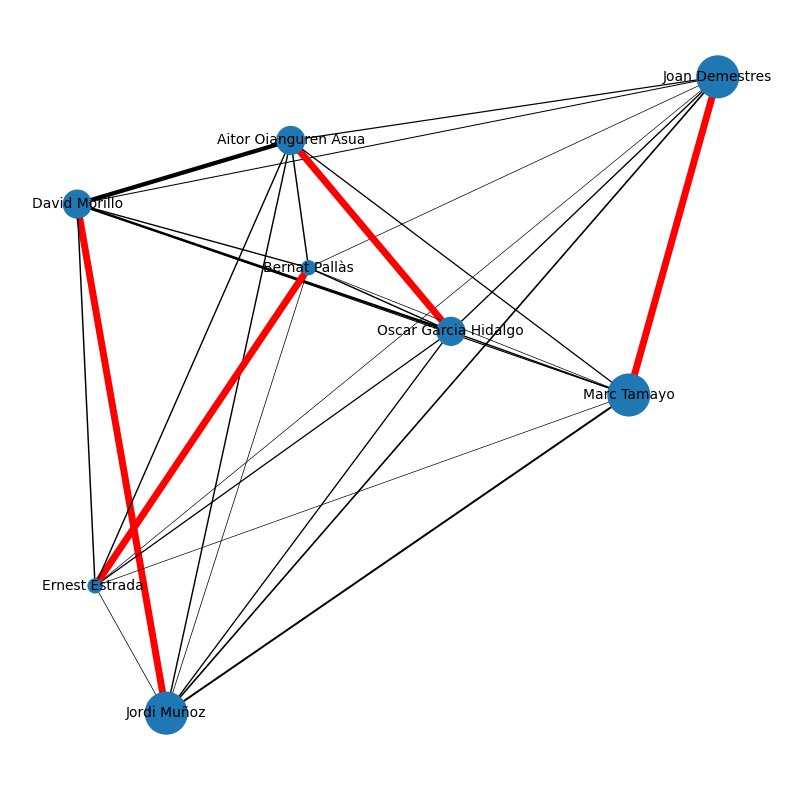

Combates:
    Oscar Garcia Hidalgo (80 kg) VS Aitor Oianguren Asua (71 kg) --> Dist: 0.12297642431484247
    Jordi Muñoz (64 kg) VS David Morillo (59 kg) --> Dist: 0.47752943317276086
    Marc Tamayo (90 kg) VS Joan Demestres (95 kg) --> Dist: 0.073226908341769
    Bernat Pallàs (72 kg) VS Ernest Estrada  (60 kg) --> Dist: 0.16482406796527713

Total execution time: 1.0201497077941895 seconds


In [ ]:
if __name__ == "__main__":
    main()